In [25]:
library(here)
setwd(here())
print(getwd())
source(file="misc_functions.R")
source(file="experiments/learning_curve/learning_curve.R")
source(file="experiments/titanic_challenge/1_feature_engineering.R")

library(lattice)
library(gridExtra)
library(mice)
library(ggplot2)

library(randomForest)
library(e1071)
library(xgboost)

[1] "/home/sapristi/Documents/ML"


In [36]:
test.raw <- read.csv("datasets/titanic_na/test.csv", 
                      colClasses = c("Sex" = "factor", "Embarked" = "factor"))

train.raw <- read.csv("datasets/titanic_na/train.csv", 
                      colClasses = c("Survived" = "factor", "Sex" = "factor", "Embarked" = "factor"))

train.to_complete <- fe$forge_features_add(train.raw, more_tickets = test.raw$Ticket)

library(mice)
imp <-  mice(train.to_complete, m=5,  printFlag = FALSE, formulas = list(Age = Age ~ Title, Age.simple = Age.simple ~ Title, 
                                                                         Fare = Fare ~ Pclass, Fare.log = Fare.log ~ Pclass))
train <- complete(imp, 1)

print(summary(train))

  PassengerId    Survived     Pclass     
 Min.   :  1.0   0:549    Min.   :1.000  
 1st Qu.:223.5   1:342    1st Qu.:2.000  
 Median :446.0            Median :3.000  
 Mean   :446.0            Mean   :2.309  
 3rd Qu.:668.5            3rd Qu.:3.000  
 Max.   :891.0            Max.   :3.000  
                                         
                                    Name         Sex           Age       
 Abbing, Mr. Anthony                  :  1   female:314   Min.   : 0.00  
 Abbott, Mr. Rossmore Edward          :  1   male  :577   1st Qu.:21.00  
 Abbott, Mrs. Stanton (Rosa Hunt)     :  1                Median :28.00  
 Abelson, Mr. Samuel                  :  1                Mean   :29.81  
 Abelson, Mrs. Samuel (Hannah Wizosky):  1                3rd Qu.:38.00  
 Adahl, Mr. Mauritz Nils Martin       :  1                Max.   :80.00  
 (Other)                              :885                               
     SibSp           Parch             Ticket         Fare        
 Min.

In [37]:
make_learning_curves <- function(model_funs, predict_funs, train, test, target, features, steps, variations, limit=NULL, title = NULL) {
    plot <- NULL
    for (model in names(model_funs)) {
        model_fun <- model_funs[[model]]
        predict_fun <- predict_funs[[model]]
        plot <- learning_curve$plot.advanced(train, test, target, features, model_fun, predict_fun, 
                                             steps, limit = limit, variations = variations, title = model, previous_plot = plot)
    }
    complete_title = paste(title, variations, "variations")
    plot <- learning_curve$make_decor(plot, complete_title, ymin=0.5)
    return(plot)
}

In [59]:


svm.linear.model_fun  <- function(train, target, features) {
    formula <- paste(target, paste(features, collapse = "+"), sep="~")  
    return(svm(as.formula(formula), 
             data = train, kernel="linear", cost=50, coef0=1,
             type="C-classification"))
}

svm.poly.model_fun  <- function(train, target, features) {
    formula <- paste(target, paste(features, collapse = "+"), sep="~")  
    return(svm(as.formula(formula), 
             data = train, kernel="polynomial", degree=3, cost=50, coef0=1,
             type="C-classification"))
}

rf.model_fun <- function(train, target, features) {
    formula <- paste(target, paste(features, collapse = "+"), sep="~")  
    randomForest(as.formula(formula), 
               data = train, na.action = na.roughfix)
}

xgb.model_fun <- function(train, target, features) {
  train.data <-  data.matrix(train[,  features])
#  print(summary(as.numeric(train[[target]])-1))
    label = as.numeric(train[[target]])-1
  xgboost(data = train.data, label = label, nrounds = 50, verbose = 0,
          objective = "binary:logistic",eval.metric = "logloss")
}

xgb.predict_fun  <- function(model, data, target, features) {
  test.data <-  data.matrix(data[,  features])
  learning_curve$discretize(predict(model, as.matrix(test.data)))
  }



In [64]:

source(file="experiments/learning_curve/learning_curve.R")
features <- c("Pclass","Fare.log", "Age.simple", "Sex")

#model_funs <- list(svm.linear = svm.linear.model_fun, svm.poly = svm.poly.model_fun, rf = rf.model_fun, xgb = xgb.model_fun)
model_funs <- list( xgb = xgb.model_fun, rf = rf.model_fun)

predict_funs <- list(xgb = xgb.predict_fun)

p <- make_learning_curves(model_funs, predict_funs=predict_funs, train=train, test=0.1, target="Survived",  features=features, 
                          steps=20, variations = 10, title = "full features")


[1] "10.000000 of the train data will be used as test set for each variation "
[1] "10.000000 of the train data will be used as test set for each variation "


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 2 rows containing non-finite values (stat_summary_bin).”Warning message:
“Removed 2 rows containing non-finite values (stat_summary_bin).”Warning message:
“Removed 6 rows containing non-finite values (stat_summary_bin).”Warning message:
“Removed 6 rows containing non-finite values (stat_summary_bin).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”

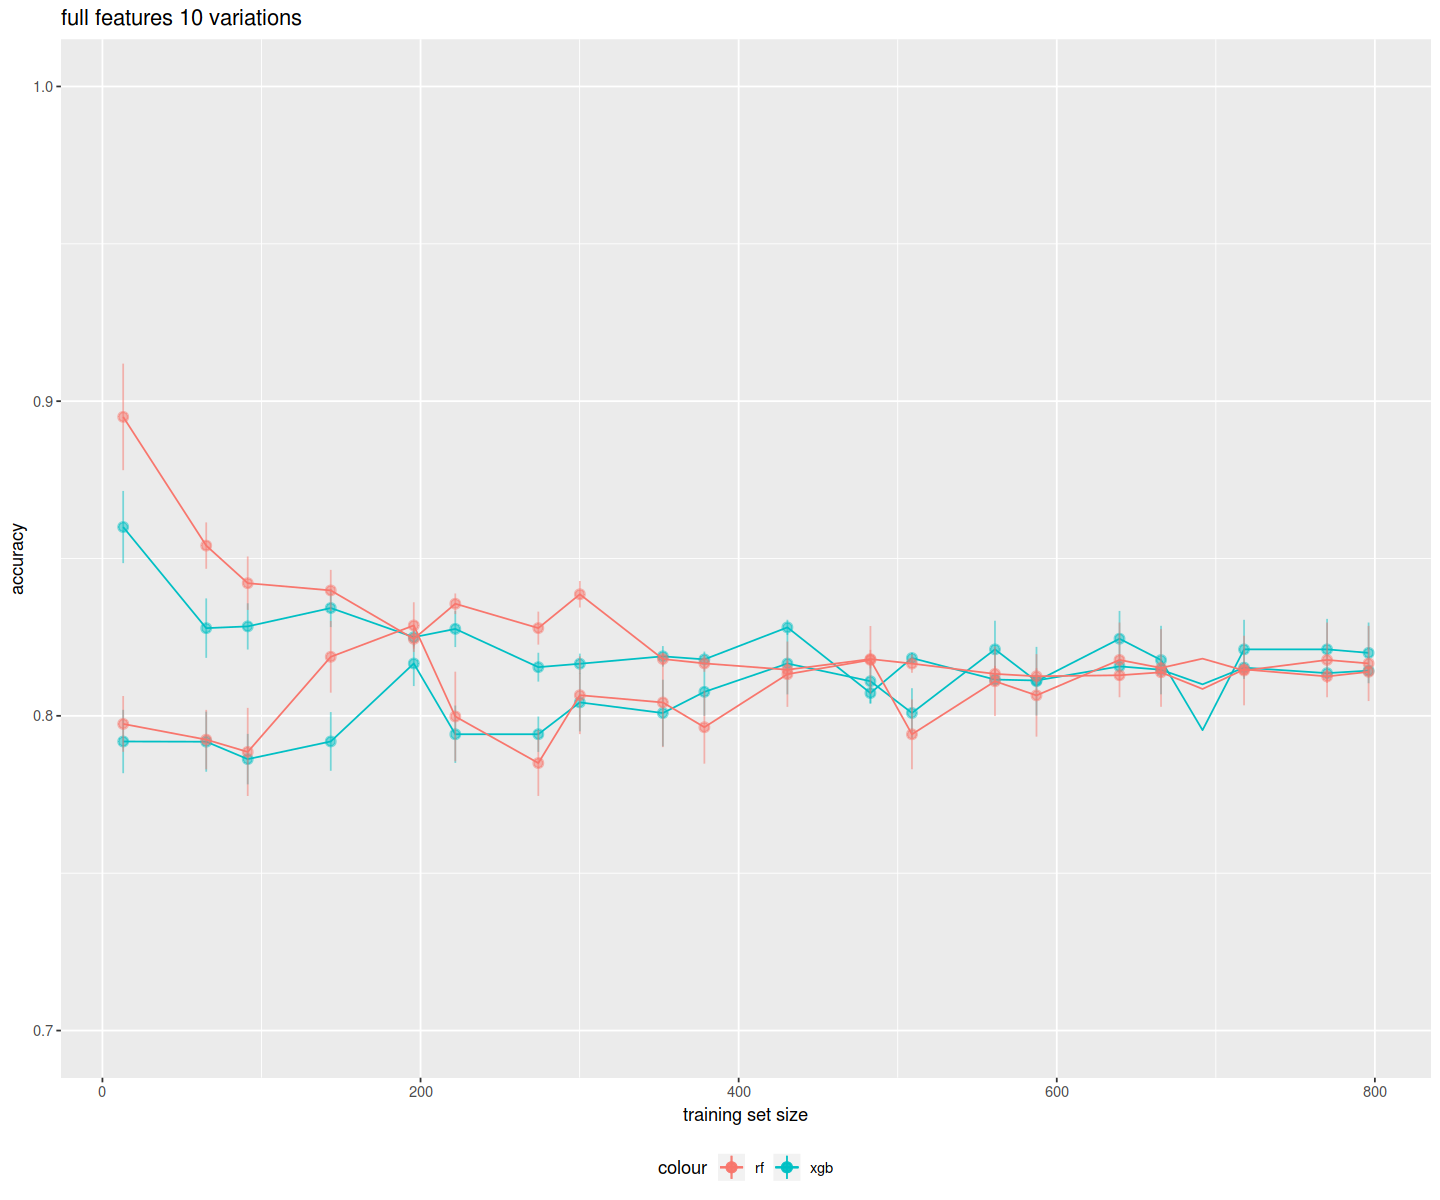

In [65]:
options(repr.plot.height= 10,repr.plot.width= 12)
p <-learning_curve$make_decor(p, ymin=0.7)
print(p)

In [66]:
train$Pclass <-as.factor(train$Pclass)
features <- c("Pclass","Fare.log", "Age.simple", "Sex")

#model_funs <- list(svm.linear = svm.linear.model_fun, svm.poly = svm.poly.model_fun, rf = rf.model_fun, xgb = xgb.model_fun)
model_funs <- list( xgb = xgb.model_fun, rf = rf.model_fun)

predict_funs <- list(xgb = xgb.predict_fun)

p <- make_learning_curves(model_funs, predict_funs=predict_funs, train=train, test=0.1, target="Survived",  features=features, 
                          steps=20, variations = 10, title = "full features")


[1] "10.000000 of the train data will be used as test set for each variation "
[1] "10.000000 of the train data will be used as test set for each variation "


Warning message:
“Removed 1 rows containing non-finite values (stat_summary_bin).”Warning message:
“Removed 1 rows containing non-finite values (stat_summary_bin).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”

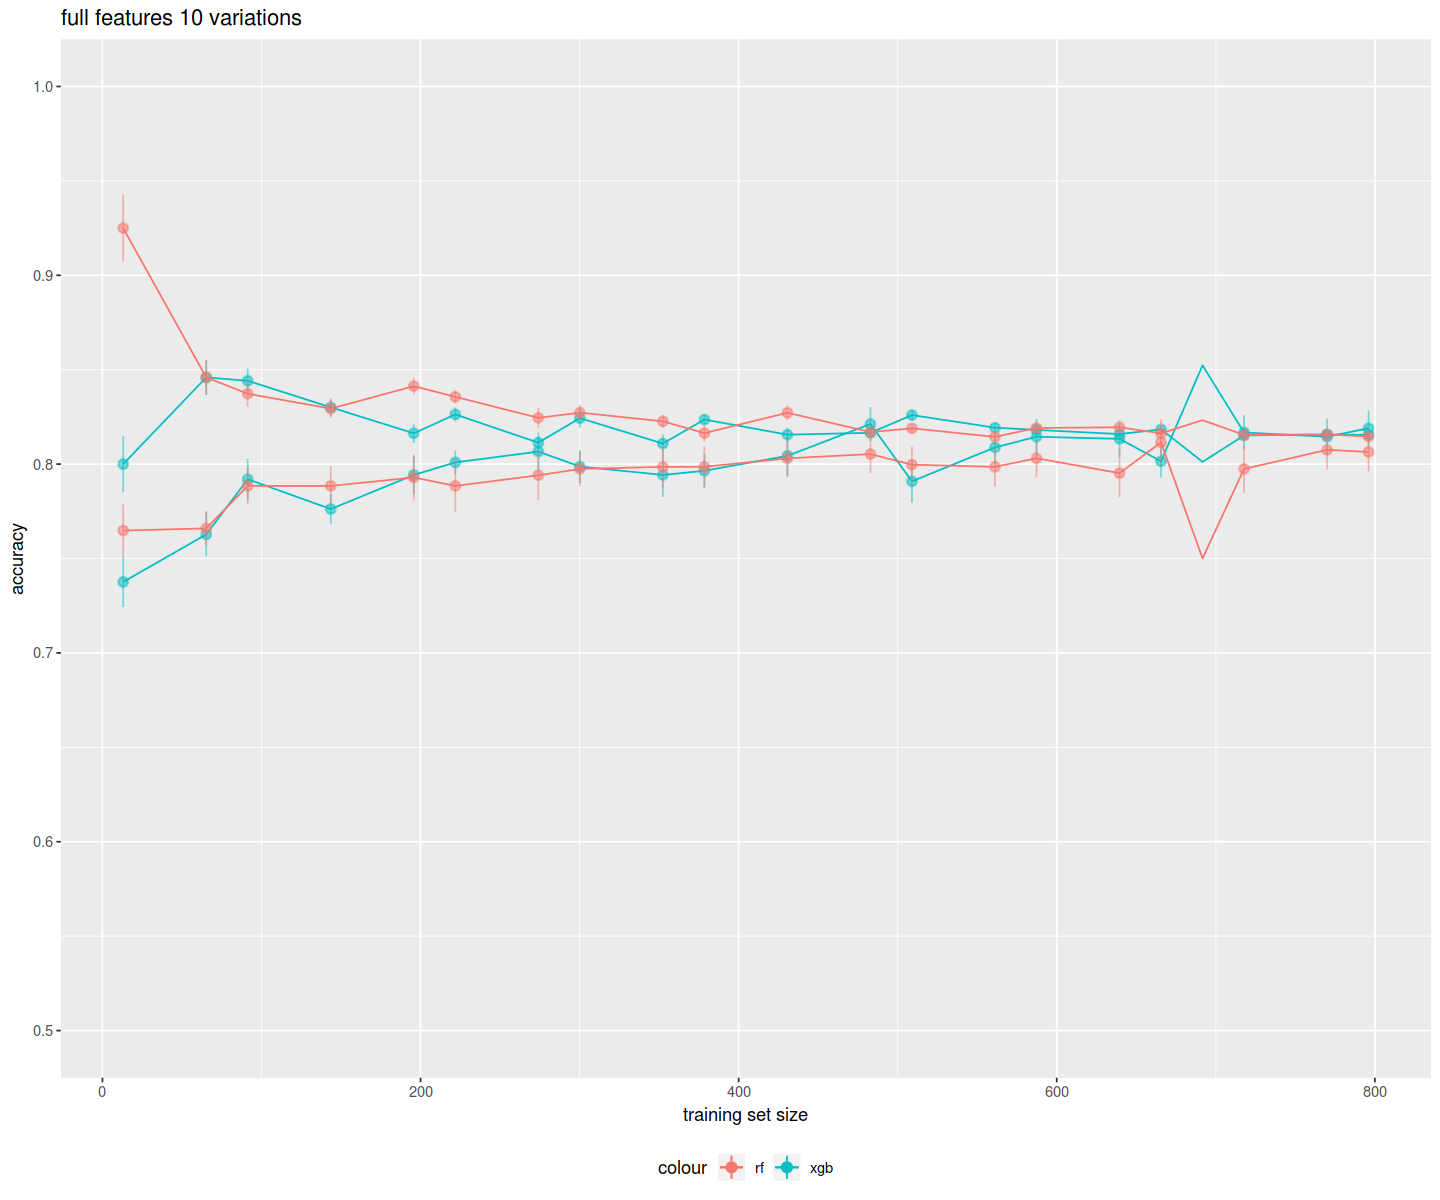

In [67]:
print(p)

In [68]:
train$Pclass <-as.factor(train$Pclass)
features <- c("Pclass","Age", "Fare", "Title")

#model_funs <- list(svm.linear = svm.linear.model_fun, svm.poly = svm.poly.model_fun, rf = rf.model_fun, xgb = xgb.model_fun)
model_funs <- list( xgb = xgb.model_fun, rf = rf.model_fun)

predict_funs <- list(xgb = xgb.predict_fun)

p <- make_learning_curves(model_funs, predict_funs=predict_funs, train=train, test=0.1, target="Survived",  features=features, 
                          steps=20, variations = 10, title = "full features")

[1] "10.000000 of the train data will be used as test set for each variation "
[1] "10.000000 of the train data will be used as test set for each variation "


Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”

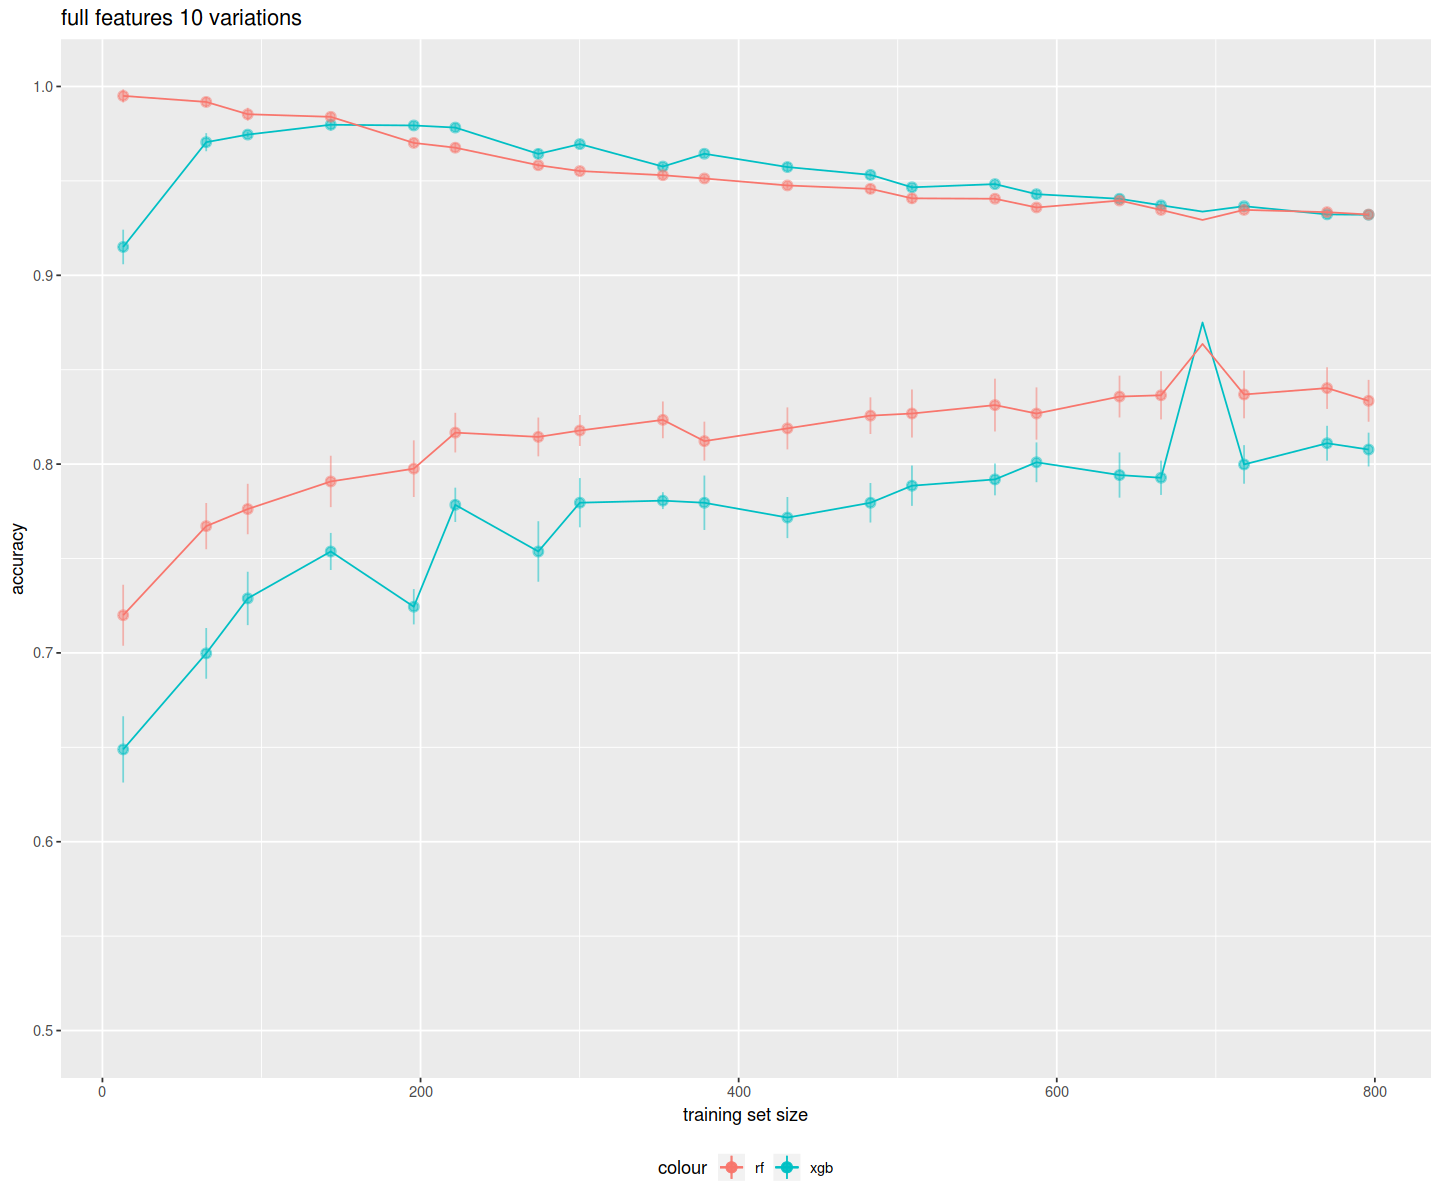

In [69]:
print(p)

In [70]:
train$Pclass <-as.factor(train$Pclass)
features <- c("Pclass","Age", "Fare", "Title", "Sex")

#model_funs <- list(svm.linear = svm.linear.model_fun, svm.poly = svm.poly.model_fun, rf = rf.model_fun, xgb = xgb.model_fun)
model_funs <- list( xgb = xgb.model_fun, rf = rf.model_fun)

predict_funs <- list(xgb = xgb.predict_fun)

p <- make_learning_curves(model_funs, predict_funs=predict_funs, train=train, test=0.1, target="Survived",  features=features, 
                          steps=20, variations = 10, title = "full features")

[1] "10.000000 of the train data will be used as test set for each variation "
[1] "10.000000 of the train data will be used as test set for each variation "


Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”

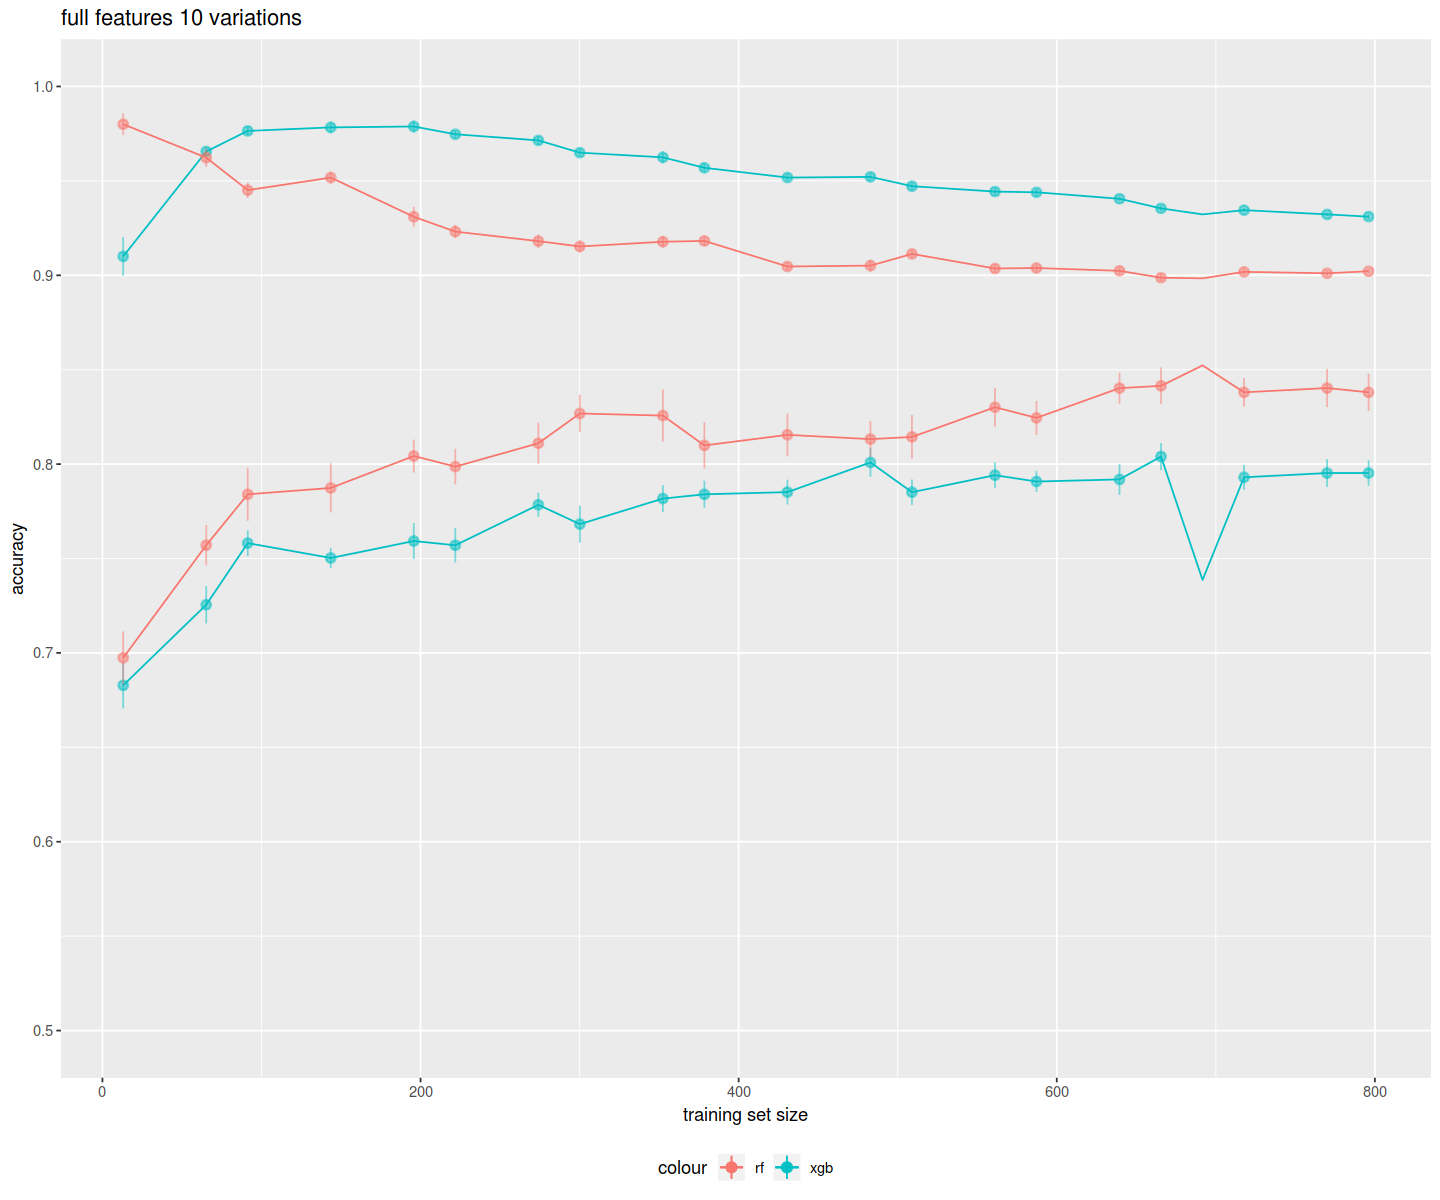

In [71]:
print(p)

In [73]:
train$Pclass <-as.factor(train$Pclass)
features <- c("Pclass","Age", "Fare", "Title", "Sex", "Parch", "SibSp")

#model_funs <- list(svm.linear = svm.linear.model_fun, svm.poly = svm.poly.model_fun, rf = rf.model_fun, xgb = xgb.model_fun)
model_funs <- list( xgb = xgb.model_fun, rf = rf.model_fun)

predict_funs <- list(xgb = xgb.predict_fun)

p <- make_learning_curves(model_funs, predict_funs=predict_funs, train=train, test=0.1, target="Survived",  features=features, 
                          steps=20, variations = 10, title = "full features")

[1] "10.000000 of the train data will be used as test set for each variation "
[1] "10.000000 of the train data will be used as test set for each variation "


Warning message:
“Removed 1 rows containing non-finite values (stat_summary_bin).”Warning message:
“Removed 1 rows containing non-finite values (stat_summary_bin).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”

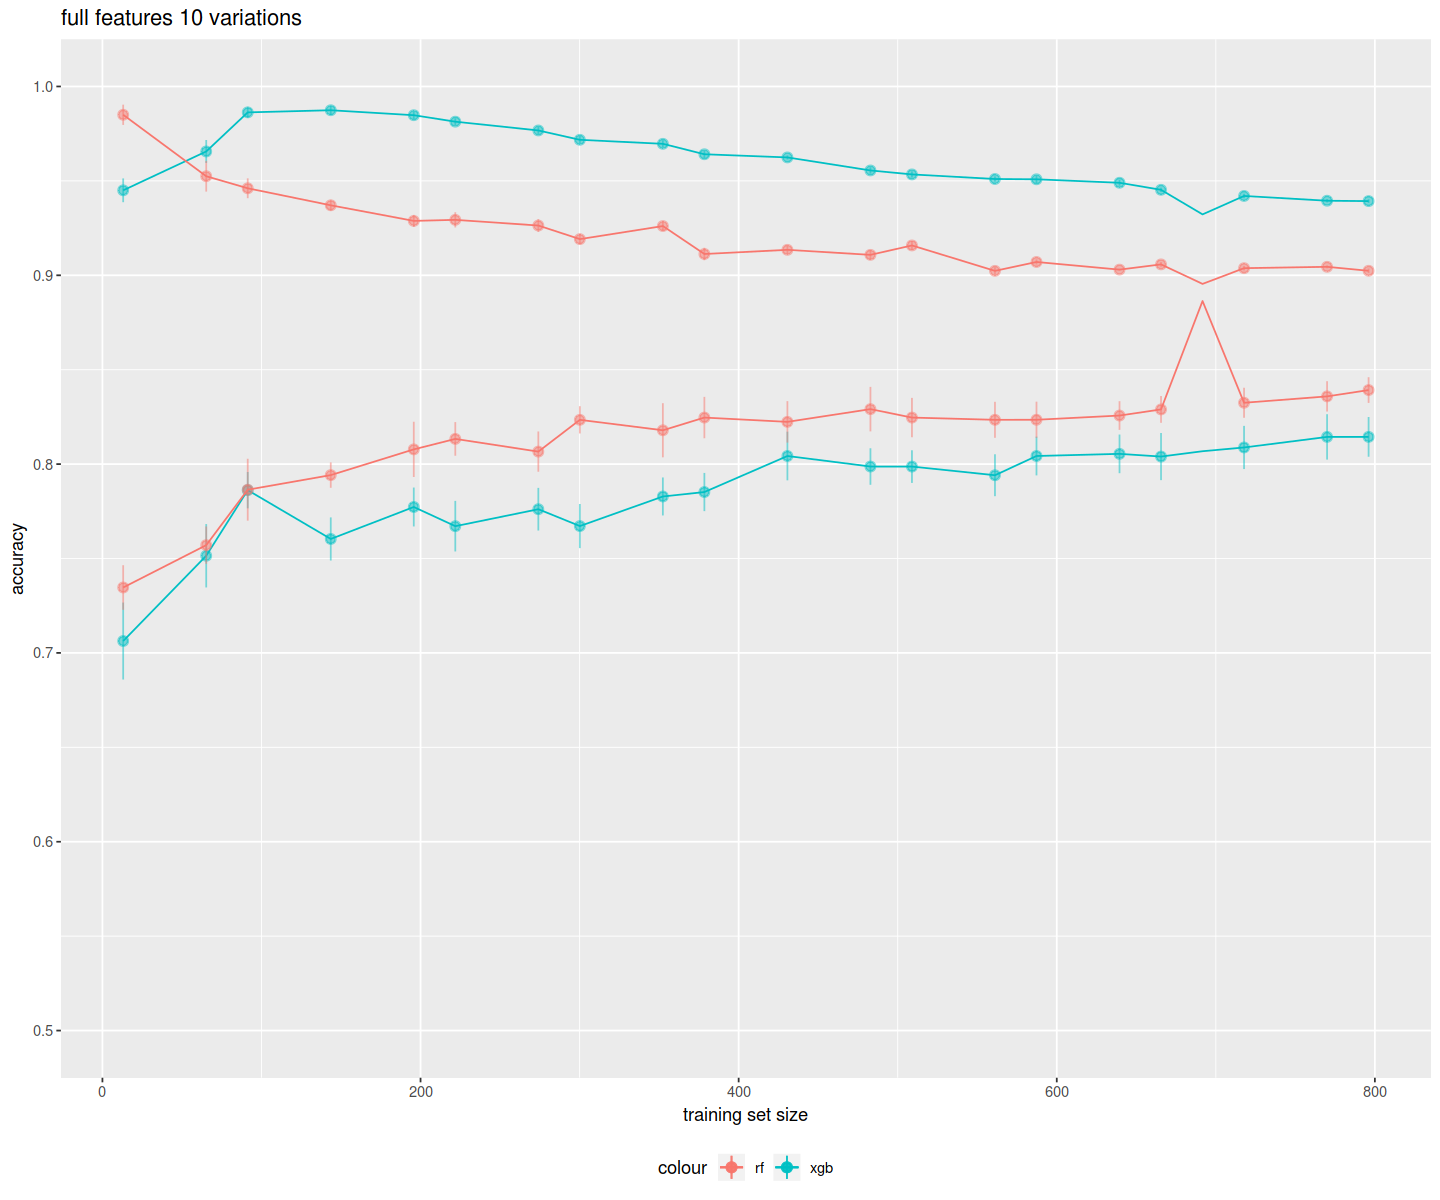

In [74]:
print(p)

In [75]:
train$Pclass <-as.factor(train$Pclass)
features <- c("Pclass","Fare.log", "Age.simple","Title", "Sex", "Parch", "SibSp")

#model_funs <- list(svm.linear = svm.linear.model_fun, svm.poly = svm.poly.model_fun, rf = rf.model_fun, xgb = xgb.model_fun)
model_funs <- list( xgb = xgb.model_fun, rf = rf.model_fun)

predict_funs <- list(xgb = xgb.predict_fun)

p <- make_learning_curves(model_funs, predict_funs=predict_funs, train=train, test=0.1, target="Survived",  features=features, 
                          steps=20, variations = 10, title = "full features")

[1] "10.000000 of the train data will be used as test set for each variation "
[1] "10.000000 of the train data will be used as test set for each variation "


Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”

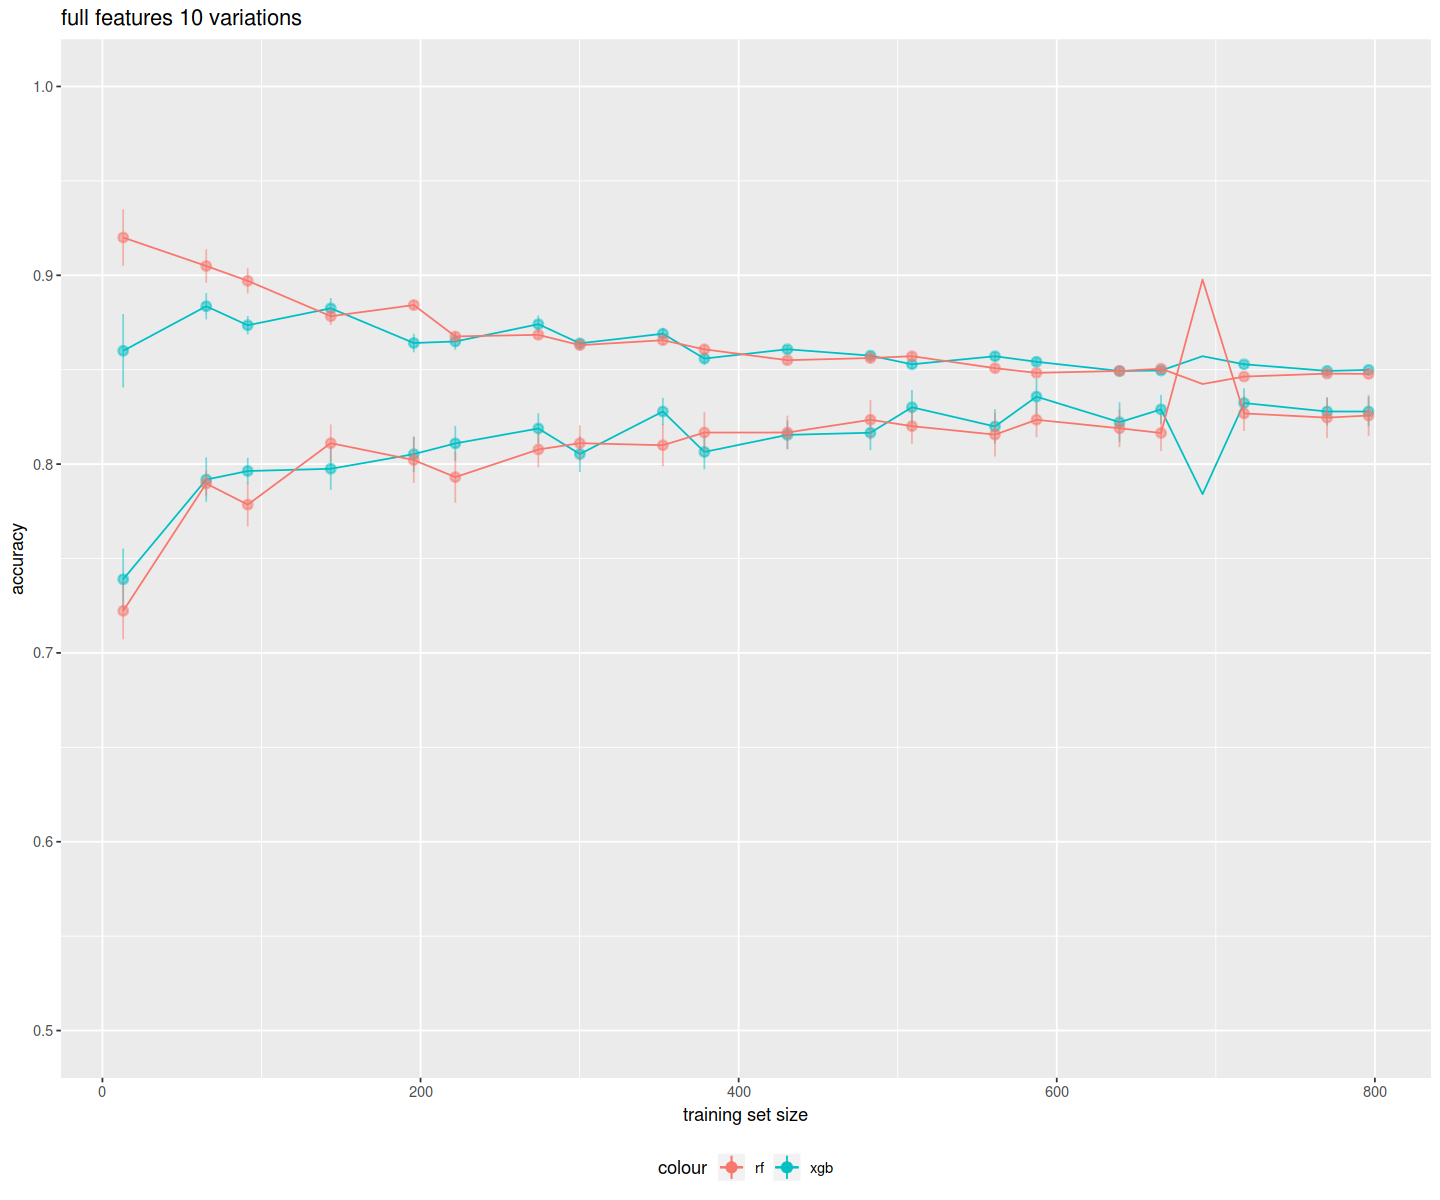

In [76]:
print(p)